In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import disable_jit, random
from numpyro.infer import HMC, MCMC, NUTS, DiscreteHMCGibbs, HMCGibbs, Predictive
from numpyro.util import control_flow_prims_disabled, optional


def model(probs, locs):
    c = numpyro.sample("c", dist.Categorical(probs))
    numpyro.sample("x", dist.Normal(locs[c], jnp.sqrt(0.1)))


probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])
predictive = Predictive(model, {}, num_samples=int(1e7), return_sites=["x"])
actual_samples = predictive(random.PRNGKey(1), probs, locs)["x"]

In [2]:
%%time
inner_kernel = NUTS(model)
gibbs_fn = discrete_gibbs_fn(model, (probs, locs), modified=True)
kernel = HMCGibbs(NUTS(model), gibbs_fn, gibbs_sites=["c"])
mcmc = MCMC(kernel, 1000, int(2e7), progress_bar=False, thinning=20)
mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.65      1.01      2.00      0.00      3.00   9438.68      1.00
         x      1.30      2.05      1.69     -2.06      4.33   9648.24      1.00

CPU times: user 1min 8s, sys: 151 ms, total: 1min 8s
Wall time: 1min 8s


In [3]:
%%time
from numpyro.infer.mixed_hmc import MixedHMC

inner_kernel = HMC(model, step_size=0.6, trajectory_length=20 * 0.6)
kernel = MixedHMC(inner_kernel, discrete_sites=["c"], num_trajectories=20)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.64      1.02      2.00      0.00      3.00   5089.30      1.00
         x      1.28      2.06      1.67     -2.09      4.31   5200.65      1.00

CPU times: user 26.1 s, sys: 48.1 ms, total: 26.2 s
Wall time: 26.1 s


In [4]:
%%time
from numpyro.infer.mixed_hmc import MixedHMCGibbs

inner_kernel = NUTS(model)
kernel = MixedHMCGibbs(inner_kernel, discrete_sites=["c"], num_trajectories=20)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.66      1.00      2.00      0.00      3.00   8407.53      1.00
         x      1.32      2.03      1.70     -2.03      4.34   8604.29      1.00

CPU times: user 54.3 s, sys: 47.9 ms, total: 54.3 s
Wall time: 54.3 s


In [5]:
%%time
from numpyro.infer.mixed_hmc import MixedHMCGibbs

inner_kernel = NUTS(model)
kernel = MixedHMCGibbs(inner_kernel, discrete_sites=["c"], num_trajectories=20,
                       discrete_temperature=1., keep_hmc_kinetic_energy=True)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.61      1.03      2.00      0.00      3.00  13961.66      1.00
         x      1.22      2.09      1.61     -2.14      4.24  14275.82      1.00

CPU times: user 50.1 s, sys: 60 ms, total: 50.1 s
Wall time: 50.1 s


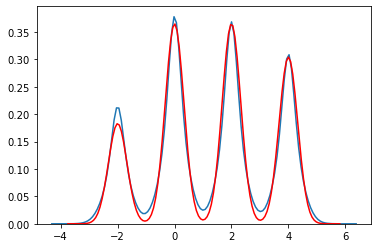

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x_samples.reshape(-1).copy())
sns.kdeplot(actual_samples.copy(), color="r");

In [7]:
%%time
from numpyro.infer.mixed_hmc import MixedHMCGibbs

inner_kernel = NUTS(model)
kernel = MixedHMCGibbs(inner_kernel, discrete_sites=["c"], num_trajectories=20,
                       discrete_temperature=0.1, keep_hmc_kinetic_energy=True)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
# assert abs(jnp.mean(x_samples) - 1.3) < 0.1
# assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.55      1.08      2.00      0.00      3.00 159928.97      1.00
         x      1.09      2.16      1.20     -2.17      4.23 157382.24      1.00

CPU times: user 51.2 s, sys: 64 ms, total: 51.3 s
Wall time: 51.3 s


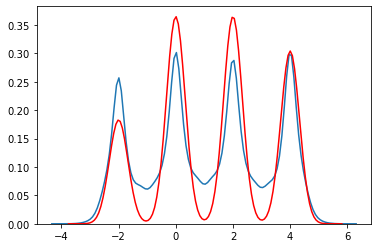

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x_samples.reshape(-1).copy())
sns.kdeplot(actual_samples.copy(), color="r");